In [1]:
import numpy as np
import numba
import pandas as pd
import collections
import scipy.optimize
import statsmodels.tools.numdiff as smnd
import bebi103
# Import pyplot for plotting
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math as m
import corner
from scipy.integrate import trapz, simps
import emcee

# Some pretty Seaborn settings
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline
%matplotlib inline

In [2]:
df = pd.read_csv('../data/hiv_data.csv', comment='#')

We will assume that the errors are normally distributed.

In [3]:
df

,Days after administration,RNA copies per mL
0,0.0000,106100.0
1,0.0831,93240.0
2,0.1465,166720.0
3,0.2587,153780.0
4,0.4828,118800.0
5,0.7448,116900.0
6,0.9817,109570.0
7,1.2563,111350.0
8,1.4926,74388.0
9,1.7299,83291.0


We need to guess which sigma_min and sigma_max to use in the prior function. We will use the difference between the data and the best fit curve we drew in homework 3. For convenience, we're attaching the code from the previous assignment: 

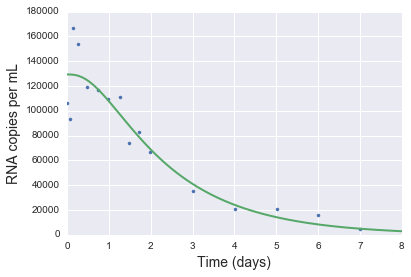

In [4]:
days = df['Days after administration'].dropna()
copies = df['RNA copies per mL'].dropna()
def findViralLoad(parameters, time):
    '''  
    Theoretical model for the viral load
    '''
    v, c, g = parameters
    return v*m.e**(-c*time) + c*v/(c-g) * ((c/(c-g) * (m.e**(-g*time) - m.e**(-c*time)) - g*time*m.e**(-c*time)))

def log_post(parameters, time, viralLoad):
    """
    Compute log of posterior for single set of parameters.
    parameters[0] = v
    parameters[1] = c
    parameters[2] = g   
    """
    # Unpack parameters
    v, c, g = parameters
    
    # Theoretical viral load
    viralTheoretical = findViralLoad(parameters, time)
    
    return -len(time) / 2 * np.log(np.sum((viralLoad - viralTheoretical)**2))

def resid(parameters, time, viralLoad):
    """
    Residuals for the fluorescence model.
    """
    return viralLoad - findViralLoad(parameters, time)

plt.plot(df['Days after administration'], df['RNA copies per mL'], marker='.', linestyle='none')
plt.xlabel('Time (days)')
plt.ylabel('RNA copies per mL')
p0 = np.array([1.061 * 10**5, 23, 16.6355323334])
args = (days.values, copies.values)
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)
x = np.linspace(0,8,200)
y = findViralLoad(popt, x)
plt.plot(x,y)
totalSum = 0   
plt.xlabel('Time (days)')
plt.ylabel('RNA copies per mL')

Our guess for the maximum error is the maximum difference between the best fit curve and the data:

In [5]:
# Let's bin the days after administration.
binned = []
y_binned = []
for i in range(len(df['Days after administration'].values)):
    difference = 1e50 # Large
    for j in range(len(x)):
        if abs(x[j]-df['Days after administration'].values[i]) < difference:
            difference = abs(x[j]-df['Days after administration'].values[i])
            value = x[j]
            index = j
    binned.append(value)
    y_binned.append(y[index])

In [6]:
max(abs(y_binned - df['RNA copies per mL'].values)), min(abs(y_binned - df['RNA copies per mL'].values))

(37666.651479018707, 146.66791573447063)

The line of code above shows that standard error ranges from 146.7 to 37,667. We will choose sigma_min = 146.7 and sigma_max = 37,667.

In [7]:
#@numba.jit(nopython=True)
def log_likelihood_gaussian(p, x, t):
    """
    Gaussian log likelihood.
    """
    c, delta, sigma = p
    v0 = 106100    
    return -(x - v_theor(p,t))**2 / 2.0 / sigma**2

def v_theor(p, t):
    c, delta, sigma = p
    v0 = 106100
    return v0 * np.exp(-c * t) + c * v0 / (c - delta) * \
           ((c / (c - delta)) * (np.exp(-delta * t) - np.exp(-c * t)) - delta * t * np.exp(-c * t))
    
#@numba.jit(nopython=True)
def log_prior_gaussian(p, c_min, c_max, delta_min, delta_max, sigma_min, sigma_max):
    """
    Log prior for fish data.
    """
    # In homework 3, we estimated c as 7.1 with a standard deviation of 1.6. In the original paper, mean c was stated as 23. 
    # We will pick c_max = 50 and c_min = 0.5. (0.5 is 4 standard deviations lower than our estimate in homework 3, so we think
    # our choice of c_min is justified.)
    # For delta, we can use delta_mean = 24 * ln(2) from the paper as a starting point. Our regressions suggest that delta = 0.53
    # with an error bar of 0.19. We will pick delta_max = 40 and delta_min = 0.
    # Finally, for sigma, we will pick sigma_min = min(error in data from 3.2) and sigma_max = max(error in data from 3.2)
    # Earlier, we found estimates for sigma_min and sigma_max as sigma_min = 146.7 and sigma_max = 37,667. 
    
    c, delta, sigma = p
    if (not (c_min < c < c_max)) or (not (delta_min < delta < delta_max)) or (not (sigma_min < sigma < sigma_max)):
        return -np.inf
    else:
        return -np.log(c_max - c_min) - np.log(delta_max - delta_min) - np.log(sigma_max - sigma_min)  #Change


#@numba.jit(nopython=True)
def log_posterior_gaussian(p, c_min, c_max, delta_min, delta_max, sigma_min, sigma_max, x, t):
    """
    Log posterior.  
    
    """
    lp = log_prior_gaussian(p, c_min, c_max, delta_min, delta_max, sigma_min, sigma_max)
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood_gaussian(p, x, t)

In [ ]:
x = df['RNA copies per mL']
t = df['Days after administration']
args=(0.5, 50, 0, 40, 146.7, 37667,x,t)
log_posterior_gaussian([1,5,1], 0, 10, 0, 10, 0, 10, x, t)

0    -6.907755e+00
1    -8.212518e+07
2    -1.850557e+09
3    -1.184697e+09
4    -1.499657e+08
5    -2.555170e+08
6    -2.754435e+08
7    -6.330245e+08
8    -2.832657e+07
9    -3.118939e+08
10   -1.412527e+08
11   -5.688901e+07
12   -4.690556e+07
13   -1.178074e+08
14   -9.204769e+07
15   -7.412069e+06
dtype: float64

In [ ]:
np.random.seed(42)
n_walkers = 50
n_dim = 3
n_burn = 1000

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_gaussian, args=args, threads=4)
# p0[i,j] is the starting point for walk i along variable j.

p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(0.5, 50, n_walkers)       # c
p0[:,1] = np.random.uniform(0, 40, n_walkers)        # delta
p0[:,2] = np.random.uniform(146.7, 37667, n_walkers)        # sigma
# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)

In [ ]:
x = type(df['RNA copies per mL'][0])
x

In [ ]:
# Seed random number generator for reproducibility
# np.random.seed(42)

# Set up parameters
# p_dict = collections.OrderedDict(
#        [('c', (np.random.uniform, (0.5, 50,))),
#         ('delta', (np.random.uniform, (0, 40.0,))),
#         ('sigma', (np.random.uniform, (146.7, 37667,)))])
#

# Run MCMC
# What should I pass as args for the Cauchy generations? How do we get the measured k_d's? 
# x = df['RNA copies per mL']
# t = df['Days after administration']
# args=(0.5, 50, 0, 40, 146.7, 37667,x,t)   



#df_mcmc = bebi103.run_ensemble_emcee(log_posterior_gaussian, p_dict=p_dict, args=args, n_walkers=50, n_burn=5000, n_steps=5000)